# Anisotropic Fast Marching to simulate karst conduit evolution #

C. Fandel 2020.
<br>Library developed by J-M Mirebeau: https://github.com/mirebeau/HamiltonFastMarching
- Documentation & worked examples: https://nbviewer.jupyter.org/github/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_FMM/Riemannian.ipynb
- Simple conceptual explanations of fast marching approaches: 
   - Isotropic: https://math.berkeley.edu/~sethian/2006/Explanations/fast_marching_explain.html
   - Anisotropic: https://math.berkeley.edu/~sethian/2006/Explanations/ordered_upwind_explain.html

**Installation**
<br>First install the necessary packages.<br>
Clone the AGD repository from GitHub, then create an environment using the environment file: <br>
`conda env create --file agd-hfm.yaml` <br>
    
Or install directly with conda: <br>
`conda install agd -c agd-lbr`

## Imports and functions ##

In [1]:
import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.Plotting import quiver
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
norm_infinity = ad.Optimization.norm_infinity
import sys
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mayavi import mlab 
import pyevtk
%matplotlib inline

In [2]:
def crop2topo(grid, dem, a=None):
    '''Crop gempy lith_block to land surface using an imported DEM raster file.
    
    Inputs:
    grid:   list [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    dem:    array of elevation values, of same xy dimensions as model, to be used for cropping.
    a:      optional: array to be cropped if not using gempy (e.g. as provided by mapping.crop2raster())
            must already be of dimensions (xres,yres,zres)
              
    Output:
    gcrop:    cropped lith_block array'''

    #Get coordinate info from grid & create VTK cells info in coord system instead of in cell indices:
    xmin = grid[0]   #min (left) coordinate
    xmax = grid[1]   #max (right) coordinate
    xres = grid[2]   #number of pixels
    ymin = grid[3]
    ymax = grid[4]
    yres = grid[5]
    zmin = grid[6]   #important: need zmin of model, NOT just DEM: model may extend below lowest point at land surface
    zmax = grid[7]
    zres = grid[8]
        
    dx   = (xmax-xmin)/xres                       #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)            #coordinates of column edges (borders between pixels)
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Get DEM & convert to topo array:
    dema = dem
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (must first convert array to float)        
    t = dema.copy()              #make a copy of elevation values directly from dem (do not use topo grid - different indexing!)

    #Get lith array:
    g = a.copy()                         #use array (make copy) (must already be 3D)
    g = g.round()                        #round to integers

    #Check dimensions for debugging:
    #print('topo shape:\t', t.shape)
    #print('lith shape:\t', g.shape)
    #print('topo min:\t',   t.min(), np.unravel_index(t.argmin(), t.shape)) #show indices of min/max of topography
    #print('topo max:\t',   t.max(), np.unravel_index(t.argmax(), t.shape))
    #print('model min:\t',  zmin) #show min/max of entire model
    #print('model max:\t',  zmax)

    #Get z indices of land surface:
    ind = (t - zmin) / dz              #calculate the cell index of each point in the dem array using the cell height (i.e. how many cells/layers up it is from the base)
    #ind = ind - 1                      #bump down by one to represent bottom of cell (this cuts lower than actual topo) 
    ind[ind==-1] = 0                   #zeros should stay zeros and not go negative
    ind = np.ceil(ind)                 #round up to nearest integer 
    ind = ind.astype(int)              #convert to integers for use as vertical indices
    #print('ind:\t', ind.shape, type(ind)) #debugging
    #print(np.unique(ind))

    #Crop off everything above the land surface:
    m = np.zeros((xres,yres))  #create array of zeroes of shape (xres,yres)
    gcrop = g.copy()           #make a copy bc need original as reference
    for x in range(xres):      #loop over x,y indices
        for y in range(yres):
            try:
                z = ind[x,y]            #get land surface elev at point (x,y)
                #m[x,y] = g[x,y,z]       #get lith value at land surface at point (x,y) - only if want to return a map
                gcrop[x,y,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
            except:
                z = ind[y,x]
                gcrop[y,x,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
    #print('map:\t', m.shape)       #for debugging
    #print('crop:\t', gcrop.shape)
    return gcrop

#################################################################
def export2vtk(sol, vtk_path, a=None):
    '''Export gempy lith_block array to VTK file (for viewing in e.g. ParaView).
    
    Inputs:
    sol:      list of model dimensions [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    vtk_path: filepath to save VTK file to (must not include any file extension)
    a:        array to export (such as a cropped lith_block)
    
    Returns:
    VTK file representing the exported array'''
    
    #Get coordinate info from grid & create VTK cells info:
    xmin = sol[0]        #min coordinate value (left)
    xmax = sol[1]        #max coordinate value (right)
    xres = sol[2]        #number of pixels
    ymin = sol[3]
    ymax = sol[4]
    yres = sol[5]
    zmin = sol[6]
    zmax = sol[7]
    zres = sol[8]
        
    dx   = (xmax-xmin)/xres                       #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)            #calculate x coordinate values of the boundaries between cells
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Format array for export:
    g = a.copy()                         #make a copy to avoid messing up original

    
    #Debugging checks:
    #print('x:', xmin,xmax,xres,dx)
    #print('y:', ymin,ymax,yres,dy)
    #print('z:', zmin,zmax,zres,dz)
    #print('shape of array to export:', g.shape)
    #plt.imshow(g[:,:,0])
    
    pyevtk.hl.gridToVTK(vtk_path, xvals, yvals, zvals, cellData={'data': g}) #export to VTK
    
###########################################################
def export2gslib(a, filename, grid):
    '''Exports a numpy array to a gslib file (GeoModeller-style format), using gempy grid objects to get the correct dimensions.
    
    Inputs: 
    a:        numpy array to be exported 
    filename: filename or path to save to
    grid:     [xres,yres,zres]
    
    Output: 
    filename.gslib: a gslib file
    '''
    
    #Format data:
    a[np.isnan(a)] = 0              #assign zeros to nan values (for SKS)
    a = np.round(a)                 #round to integers
    a = a.astype(int)               #convert from floats to integers (so that gslib file will have integers)
    
    #Get grid info
    xres = grid[0]                          #get x resolution
    yres = grid[1]                          #get y resolution
    if len(grid)==3:                        #if 3D grid
        zres = grid[2]                      #get z resolution
       
    #Format array shape:
    try:                                                #try to reshape in 3D
        a = np.reshape(a,(xres,yres,zres))              #reshape 1D array to a 3D array with correct dimensions
        a = np.reshape(a, xres*yres*zres, order='F')    #reshape 3D array back to 1D array using Fortran indexing 
    except:                                             #if 3D doesn't work, try 2D 
        a = np.reshape(a,(xres,yres))                   #reshape 1D array to a 2D array with correct dimensions
        a = np.reshape(a, xres*yres, order='F')         #reshape 2D array back to 1D array using Fortran indexing 
        
    #Export:    
    df = pd.DataFrame(a)                            #store array in a pandas dataframe
    header = pd.DataFrame(['Geologic model',1,'lith'])    #set gslib file header
    df = header.append(df)                              #attach header and data
    df.to_csv(filename, header=False, index=False)      #write a text file in gslib format

###############################################
def PointFromIndex(index, dims, origin, scale, to=False):
    '''Turns an index into a point.
    Inputs:
    index:  [ix,iy,iz] index to be converted to point coordinates
    dims:   [xres,yres,zres] number of cells along each axis
    origin: [xmin,ymin,zmin] origin point of grid
    scale:  [dx,dy,dz] the width, height, and depth of each cell or pixel
    to:     True/False, optional. If true, inverse transformation, turning a point into a continuous index
    Outputs:
    point:  [x,y,z] point coordinates corresponding to given index
    '''
    tail = np.asarray((-scale[-1]/2,)*(len(dims)-len(origin)), dtype='float')
    bottom = np.concatenate((origin,tail))
    start = bottom + 0.5*np.asarray(scale)
    index = np.asarray(index, dtype='float')
    #assert index.shape[-1]==self.vdim
    if not to: return start+scale*index      #point from index
    else:      return (index-start)/scale    #index from point
    
###########################
def IndexFromPoint(point, dims, origin, scale, to=True):
    '''Returns the index that yields the position closest to a point, and the error.
    Inputs:
    point: [x,y,z] coordinates to be converted to indices
    dims:   [xres,yres,zres] number of cells along each axis
    origin: [xmin,ymin,zmin] origin point of grid
    scale:  [dx,dy,dz] the width, height, and depth of each cell or pixel
    to:     True/False, optional. If true, inverse transformation, turning a point into a continuous index
    
    Outputs:
    index, error:  [ix,iy,iz], [errorx,errory,errorz]
    '''
    
    point = np.asarray(point, dtype='float')
    continuousIndex = PointFromIndex(point, dims, origin, scale, to=True)
    index = np.round(continuousIndex)
    return index.astype(int),(continuousIndex-index)

#################################
def ss(A, subsampling): 
    '''Get a subsample of points to plot for quiver plots.
    Inputs:
    A: array to subsample
    subsampling: tuple (nx,ny,nz) indicating sampling interval. (5,5,5) would mean sample every fifth point'''
    
    where = tuple(slice(None,None,s) for s in subsampling)
    return A.__getitem__(where)

## Create simple block model ##
There are two geologic units:
- Limestone (1): green, low travel cost
- Shale (2): brown, high travel cost

The layers are tilted and folded into a valley draining east. A single spring drains the system. Inlets (starting points for the conduits to form) are randomly scattered across the limestone unit upgradient of the spring.

DEM array: (100, 80) 252.5 600.0
DEM indices: (100, 80) 24 59
Contact surface: (100, 80) 311.0 450.0
Contact indices: (100, 80) 30.0 43.0
Geology array: (100, 80, 60) 1.0 2.0
Geologic map: (100, 80) 1.0 2.0
Spring indices: [75, 40, 31] Spring coord: [755. 405. 315.]
Cropped geology: (100, 80, 60) 0.0 2.0


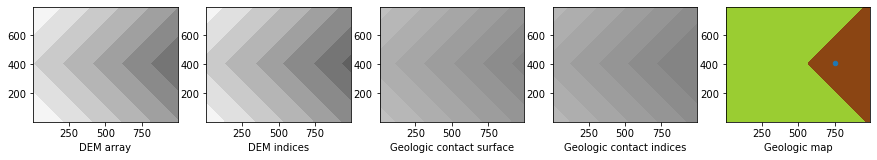

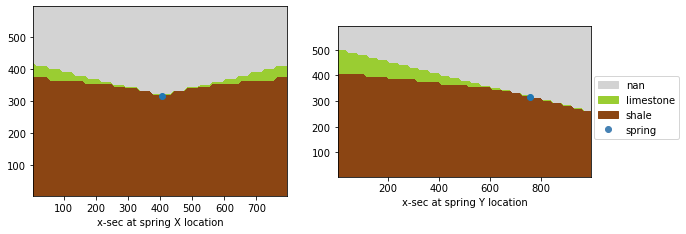

In [121]:
#Create model input object:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':     2
})

#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0

# Define grid for the model object:
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])

#Create topography array:
dema = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):                 #move west to east along x indices (columns)
    dema[ix,:] = mx*ix + dema[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):       #move down rows towards valley (north to south)
        dema[ix,iy] = my*iy + dema[ix,0]    #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):               #move down y indices (rows) away from valley (south to north)
    dema[:,iy] = dema[:,yres-iy]            #insert a mirror image of the north side of the valley
f = plt.figure(figsize=(15,5))
f.add_subplot(151, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], dema, cmap='gray', vmin=zmin,vmax=zmax) #darker=lower (don't use imshow because indexing is different)
plt.xlabel('DEM array')
print('DEM array:', dema.shape, dema.min(), dema.max())

#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dema[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #use new fn
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])   #use built-in
        idem[ix,iy] = zind-1 #correct to be index below
f.add_subplot(152, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], idem, cmap='gray', vmin=0,vmax=zres)  #0=bottom,black, 1=top,white
plt.xlabel('DEM indices')
print('DEM indices:', idem.shape, idem.min(), idem.max())

#Create geologic contact surface elevation array:
zstart = zmax - (zmax-zmin)//4
zcontact = np.full((xres,yres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.1 * dx                 #set the slope in the x direction (west to east)
my = -0.1 * dy                 #set the slope in the y direction (north to south)
valley  = yres//2              #set which row to put the valley in
for ix in range(xres):                        #move west to east along columns
    zcontact[ix,:] = mx*ix + zcontact[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(ymin,valley+1):           #move down rows towards valley (north to south)
        zcontact[ix,iy] = my*iy + zcontact[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):                      #move down rows away from valley (south to north)
    zcontact[:,iy] = zcontact[:,yres-iy]           #insert a mirror image of the north side of the valley
f.add_subplot(153, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], zcontact, cmap='gray', vmin=zmin,vmax=zmax)  
plt.xlabel('Geologic contact surface')
print('Contact surface:', zcontact.shape, zcontact.min(), zcontact.max())

#Convert from elevations to cell z indices:
icontact = np.empty((xres,yres))
for iy in range(yres):
    for ix,z in enumerate(zcontact[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        icontact[ix,iy] = zind - 1
f.add_subplot(154, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], icontact, cmap='gray', vmin=0,vmax=zres)  
plt.xlabel('Geologic contact indices')
print('Contact indices:', icontact.shape, icontact.min(), icontact.max())

#Create 3D geology array (the integer in each cell indicates the formation present in that cell):
#Important: layer 0 is at the top, layer 60 is at the bottom (NOT vice-versa)
geo = np.empty((xres,yres,zres))   #set empty 3D array of model dimensions
for ix in range(xres):            #loop over cols, rows, & layers
    for iy in range(yres):
        for iz in range(zres):             #for each cell, 
            if iz <= icontact[ix,iy]:    #if layer is below the contact index (i.e. has a lower index),
                geo[ix,iy,iz] = 2        #assign 2 for shale
            if iz > icontact[ix,iy]:     #if layer is above the contact index (i.e. has a higher index),
                geo[ix,iy,iz] = 1        #assign 1 for limestone
#export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geo', a=geo) #uncomment to export for ParaView
print('Geology array:', geo.shape, geo.min(), geo.max())    
    
#Create geologic map
geomap = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        geomap[ix,iy] = geo[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface
f.add_subplot(155, aspect='equal')
cmap = matplotlib.colors.ListedColormap(['lightgray','yellowgreen','saddlebrown']) #create custom colormap
plt.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=2)   #0:nan, gray, 1: limestone, green 2: shale, brown  
plt.xlabel('Geologic map')
print('Geologic map:', geomap.shape, geomap.min(), geomap.max())

#Define spring location:
ispring = [75,40]                          #ix,iy 
zspring = idem[ispring[0],ispring[1]]      #get surface elevation index of spring from topo array
ispring.append(int(zspring)+1)             #store spring index moved up by one to be above land surface
#springXYZ = PointFromIndex([ispring[0],ispring[1],ispring[2]], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])  #convert to coordinates
springXYZ = hfmIn.PointFromIndex([ispring[0],ispring[1],ispring[2]])
plt.scatter(springXYZ[0], springXYZ[1], s=20)    #show spring location
print('Spring indices:',ispring, 'Spring coord:', springXYZ)
springdf = pd.DataFrame(springXYZ,index=['x','y','z']).T  #convert to df for easier export
springdf.to_csv('spring.csv',header=True,index=False)     #export to csv for viewing in ParaView

#Crop & export:
geocrop  = crop2topo([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], dema, geo)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geocrop', a=geocrop)  #uncomment to export for ParaView
export2gslib(geocrop, 'geocrop.gslib', [xres,yres,zres])                            #export to GSLIB for SKS
print('Cropped geology:', geocrop.shape, geocrop.min(), geocrop.max() )

#Plot sliced views:
f,ax = plt.subplots(1,2, figsize=(10,5), subplot_kw={'aspect':'equal'})
ax[0].contourf(Y[0,:,:],Z[0,:,:], geocrop[ispring[0],:,:], cmap=cmap, vmin=0,vmax=2)   #0:nan, gray, 1: limestone, green 2: shale, brown  
ax[0].scatter(springXYZ[1],springXYZ[2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], geocrop[:,ispring[1],:], cmap=cmap, vmin=0,vmax=2)
ax[1].scatter(springXYZ[0],springXYZ[2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
ax[1].legend((matplotlib.patches.Patch(color='lightgray'),
              matplotlib.patches.Patch(color='yellowgreen'),
              matplotlib.patches.Patch(color='saddlebrown'), 
              matplotlib.lines.Line2D([0],[0], marker='o', color='steelblue', linestyle='None')),
             ('nan', 'limestone', 'shale', 'spring'),
              loc=(1.01,0.25))

loading starting points
calculating elevations
tips:
 [[315.  55. 415.]
 [ 75. 665. 425.]
 [ 45. 785. 445.]
 [365. 745. 405.]
 [125. 415. 395.]]


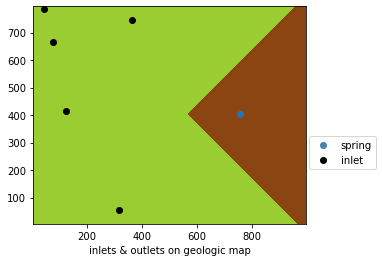

In [122]:
#Generate the inlets (starting points for the walker path calculations):
generate = False          #choose whether to generate random xy starting points or load existing from file
elev     = 'bottom'       #choose whether to start at land surface ('top') or bottom of karst ('bottom')
if generate: 
    print('generating new starting points')
    ntips = 10                                     #number of start points to generate
    tips = []
    for i in range(ntips):                         #generate random starting points
        ix = random.randrange(0,int(ispring[0]))   #get random x integer upgradient of spring
        iy = random.randrange(0,yres)              #get random y integer
        [x,y,z] = PointFromIndex([ix,iy,0], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])  #convert indices to coordinates with dummy z
        tip = [x,y,z]                              #for 3d, tip = [x,y,z]        
        tips.append(tip)                           #store
    tips = np.array(tips)                          #convert to array

else:
    print('loading starting points')
    tips = pd.read_csv('tips.csv').values          #load tips from csv and convert to array       
    
print('calculating elevations')
for i in range(len(tips)):
    x = tips[i,0]                              #get x coord
    y = tips[i,1]                              #get y coord
    [ix,iy,iz],error = IndexFromPoint([x,y,0], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #convert to indices with dummy z values
    if elev=='top':
        iz = idem[ix,iy]                      #get land surface index
    if elev=='bottom':
        iz = ispring[2]                       #get spring z elevation to start at water table
        #print('starting index', col,row,lay, 'unit', geo[col,row,lay])
        while geo[ix,iy,iz] > 1:      #if the point is below the karst unit (karst=1, unit numbers increase going down)
            iz = iz + 1               #move up by one (0 is bottom?)
            #print('point is below karst unit - move index up one', col,row,lay, 'unit', geo[col,row,lay])
            if iz > zres:             #if exit upper model boundary
                #print('exited upper model boundary - reset to spring elevation')
                iz = ispring[2]       #reset to spring elevation
                break                 #exit while loop
        #print('ending index', col,row,lay,'unit', geo[col,row,lay])
    [x,y,z] = PointFromIndex([ix,iy,iz],  [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])  #convert indices back to coordinates
    tips[i,2] = z    #store z coord

#Export to csv for saving and viewing in ParaView
tipsdf = pd.DataFrame(tips, columns=['x','y','z'], index=np.arange(len(tips))) #convert to df for export
tipsdf.to_csv('tips.csv',header=True,index=False) #export to csv  
print('tips:\n', tips)

#Plot map:
f,ax = plt.subplots(1,1, subplot_kw={'aspect':'equal'})
ax.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=2)
ax.scatter(springXYZ[0], springXYZ[1])
ax.scatter(tips[:,0],tips[:,1], c='k')
ax.set_xlabel('inlets & outlets on geologic map')
plt.legend((matplotlib.lines.Line2D([0],[0], marker='o', color='steelblue', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], marker='o', color='k',         linestyle='None')),
            ('spring', 'inlet'), loc=(1.01,0.25))

### Set up Anisotropic Fast Marching (3D) ###

In [123]:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':     2
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])

#Assign springs (ending points for walkers):
hfmIn['seed'] = springXYZ

#Assign starting points for walkers:
hfmIn['tips'] = tips        #assign starting points for walkers (array of x,y,z coordinates)

# Assign different travel costs to different units:
#NOTE: THIS IS NOT CURRENTLY WORKING!!!
#cost is an array of dim(xres,yres,zres) with the value in each cell indicating how difficult it is 
#to travel through that cell (higher value=harder to travel through)
cost = geocrop.copy()       #make copy to not mess up original (0: nan, 1: limestone, 2: shale ) 
cost[np.isnan(cost)] = 999  #assign very high cost to areas outside model boundary
cost[cost==1] = 1           #assign low cost to limestone
cost[cost==2] = 100         #assign higher cost to shale
hfmIn['cost'] =  cost       #give this info to the algorithm


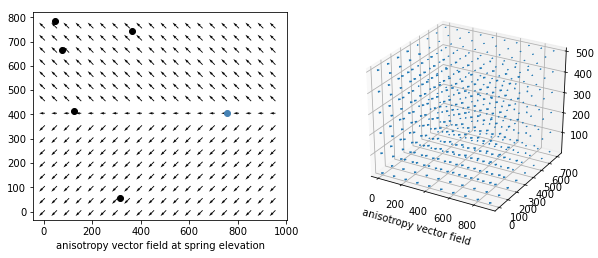

In [156]:
#Set anisotropy field:
#Must be opposite direction - will be reversed in the algorithm
X,Y,Z = hfmIn.Grid()  #get model grid

#Use stacked arrays of the topography at the contact between limestone and shale:
V = np.repeat(zcontact[:,:,np.newaxis], zres, axis=2)  #create a 3D array where elevation array is repeated on each layer
DxV,DyV,DzV = np.gradient(V, dx,dy,dz, axis=(0,1,2))   #x and y components of gradient in each cell of array 

#Assign position-dependent cost?
run=True
if run:
    alpha = np.full(V.shape,   0.2) #set up array of default alpha values
    alpha[np.isnan(geocrop)] = 0.9  #assign high cost to areas outside model boundary
    alpha[geocrop==1]        = 0.1  #assign low cost to limestone
    alpha[geocrop==2]        = 0.6  #assign medium-high cost to shale
    beta  = np.full(V.shape,   0.8) #set up array of default beta values
    beta[np.isnan(geocrop)]  = 0.9  #assign high cost to areas outside model boundary
    beta[geocrop==1]         = 0.3  #assign low cost to limestone
    beta[geocrop==2]         = 0.8  #assign medium-high cost to shale
    
#Assign uniform cost:
run=False
if run:
    alpha = 0.2      #travel cost parallel to vector direction (0.2)
    beta  = 0.8      #travel cost orthogonal to vector direction (0.8)
    
F = Riemann.needle([DxV,DyV,DzV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
hfmIn['metric']    =  F                        #assign to model

#Plot anisotropic vector field (2D cross-section):
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(1,2,1)
ax.set_aspect('equal')
ax.set_xlabel('anisotropy vector field at spring elevation')
subsample=(5,5)      #subsample every nth point to make plot less crowded
ax.quiver(ss(X[:,:,ispring[2]],subsample),ss(Y[:,:,ispring[2]],subsample), 
          ss(DxV[:,:,ispring[2]],subsample),ss(DyV[:,:,ispring[2]],subsample))
ax.scatter(springXYZ[0],springXYZ[1],c='steelblue')
ax.scatter(tips[:,0],tips[:,1],c='k')

#Plot in 3D:
ax = f.add_subplot(1,2,2, projection='3d')
ax.set_xlabel('anisotropy vector field')
subsample=(10,10,10)      #subsample every nth point to make plot less crowded
ax.quiver(ss(X,subsample),ss(Y,subsample),ss(Z,subsample), 
          ss(DxV,subsample),ss(DyV,subsample),ss(DzV,subsample), length=100) 

In [157]:
#Select desired outputs and run model:
hfmIn['exportValues'] = 1
hfmIn['exportGeodesicFlow'] = 1

hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.534 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [158]:
#Export resulting conduit paths for ParaView:
paths = hfmOut['geodesics']
pathsa = np.concatenate(paths, axis=1)                   #concatenate into array
pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T
pathsdf.to_csv('paths.csv',header=True,index=False)       #export to csv for ParaView

### View results ###
For best visualization, use ParaView

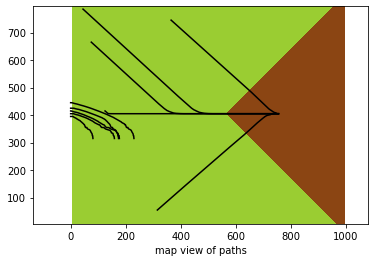

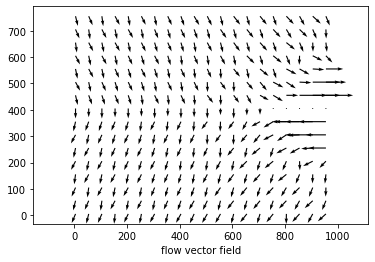

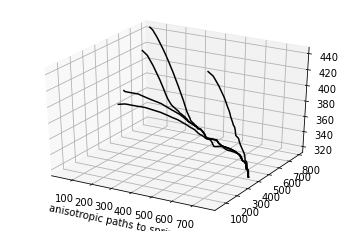

In [159]:
#Plot cross-section of results:
plt.figure()
plt.xlabel('map view of paths')
plt.axis('equal')
plt.contourf(X[:,:,ispring[2]],Y[:,:,ispring[2]],geomap, cmap=cmap, vmin=0,vmax=2) #travel cost
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(*path, c='k')

#Plot flow field:
plt.figure();
plt.xlabel('flow vector field')
plt.axis('equal')
quiver(X[:,:,ispring[2]],Y[:,:,ispring[2]], *hfmOut['flow'][[1,2],:,:,ispring[2]], subsampling=(5,5))

#Plot results in 3D:
ax = plt.figure().gca(projection='3d')
ax.set_xlabel('anisotropic paths to spring')
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    plt.plot(*path, c='k')

In [160]:
#Plot in Mayavi pop-up window:
#Travel time:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
values = hfmOut['values'] #get travel time values
values[np.isinf(values)] = np.nan #remove infinite values
mlab.contour3d(X,Y,Z, values, contours=contours, opacity=0.25)

#Cost:
#contours = np.linspace(np.min(hfmIn['cost']), np.max(hfmIn['cost']), num=2).tolist() #generate contours
#mlab.contour3d(X,Y,Z, hfmIn['cost'], contours=contours)  #plot travel time

#Plot land surface:
#mlab.surf(X[:,:,0],Y[:,:,0], dema, colormap='gray')
#Plot contact surface:
mlab.surf(X[:,:,0],Y[:,:,0], zcontact, colormap='gray', opacity=0.5)

#Shortest paths:
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    mlab.plot3d(pathX,pathY,pathZ, color=(0,0,0), tube_radius=1) #plot paths
mlab.plot3d([0,0],[400,400],[500,600], color=(0,0,0), tube_radius=1*dx)  #plot short vertical line at upper western midline of area

mlab.show() # Displays in an external window. 


### Notes ###
- Why is cost function not being used?

Try:
- Read documentation about cost function - look at BoatRoutig example. May need to use obstacles.